In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import timedelta
import matplotlib.dates as mdates

# --- SETUP VISUAL ---
PALETA = {
    'historia': '#022B49',  # Azul escuro para o passado
    'previsao': '#02A556',  # Verde para o futuro (esperança/lucro)
    'intervalo': '#A5D6A7'  # Verde claro para a margem de erro
}

In [ ]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# --- 1. PREPARAÇÃO DOS DADOS ---
# Carregamos e limpamos para garantir que não existam buracos nas datas
df = pd.read_parquet('../data/processed/dados_completos_commodities.parquet')
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').asfreq('B') # 'B' = Business Days (Dias Úteis)

# Vamos focar no ARÁBICA (o mais importante para o Mercado)
# Preenchemos pequenos buracos (feriados) com o valor do dia anterior para não quebrar o modelo
serie_arabica = df['Arabica_BRL'].fillna(method='ffill')

print(f"Última Data Real: {serie_arabica.index[-1].date()}")
print(f"Último Preço Real: R$ {serie_arabica.iloc[-1]:.2f}")

Última Data Real: 2026-01-16
Último Preço Real: R$ 2522.07


C:\Users\aryma\AppData\Local\Temp\ipykernel_21464\1846902438.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie_arabica = df['Arabica_BRL'].fillna(method='ffill')


In [ ]:
# --- 2. TREINAMENTO DO MODELO (MACHINE LEARNING) ---
# Usamos Holt-Winters com:
# - Trend='add' (Tendência Aditiva: o preço sobe/desce linearmente)
# - Seasonal=None (Desativamos a sazonalidade automática pois temos dados diários complexos, 
#   para um forecast curto de 30 dias a tendência recente pesa mais)
modelo = ExponentialSmoothing(serie_arabica, 
                              trend='add', 
                              seasonal=None, 
                              damped_trend=True).fit()

# --- 3. PREVISÃO (FORECAST 30 DIAS) ---
dias_previsao = 30
previsao = modelo.forecast(dias_previsao)

# Criando um intervalo de confiança simples (Simulação de erro baseada no desvio recente)
# (Na prática, assumimos uma margem de erro de ~5% para cima ou para baixo)
desvio = serie_arabica.diff().std() * np.sqrt(np.arange(1, dias_previsao + 1))
limite_inferior = previsao - (1.96 * desvio) # 95% de confiança
limite_superior = previsao + (1.96 * desvio)

print("\n--- Previsão para os Próximos 30 Dias ---")
print(f"Preço Esperado em 30 dias: R$ {previsao.iloc[-1]:.2f}")
print(f"Cenário Otimista (Teto):   R$ {limite_superior.iloc[-1]:.2f}")
print(f"Cenário Pessimista (Piso): R$ {limite_inferior.iloc[-1]:.2f}")


--- Previsão para os Próximos 30 Dias ---
Preço Esperado em 30 dias: R$ 2524.04
Cenário Otimista (Teto):   R$ 2990.12
Cenário Pessimista (Piso): R$ 2057.96


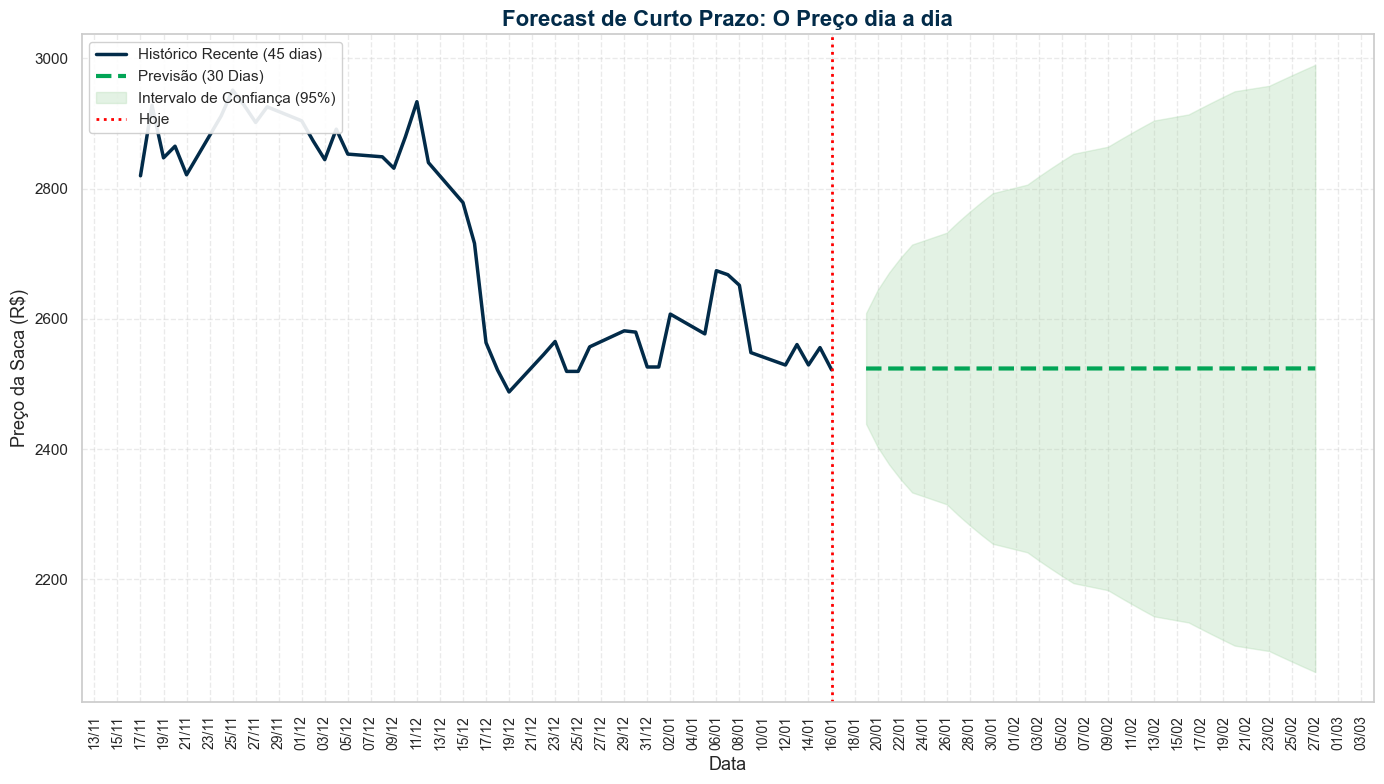

In [ ]:
# --- 4. VISUALIZAÇÃO COM ZOOM E FOCO ---
plt.figure(figsize=(14, 8)) # Aumentei um pouco a altura

# A. O Passado (Apenas os últimos 45 dias para dar "zoom" na transição)
# Menos histórico antigo = Mais espaço para ler as datas do futuro
plt.plot(serie_arabica.index[-45:], serie_arabica.tail(45), 
         label='Histórico Recente (45 dias)', color=PALETA['historia'], linewidth=2.5)

# B. O Futuro (Previsão)
plt.plot(previsao.index, previsao, 
         label='Previsão (30 Dias)', color=PALETA['previsao'], linewidth=3, linestyle='--')

# C. O Intervalo de Confiança
plt.fill_between(previsao.index, limite_inferior, limite_superior, 
                 color=PALETA['intervalo'], alpha=0.3, label='Intervalo de Confiança (95%)')

# D. Linha "HOJE"
ultima_data_real = serie_arabica.index[-1]
plt.axvline(x=ultima_data_real, color='red', linestyle=':', linewidth=2, label='Hoje')

# --- MELHORIA CRÍTICA DO EIXO X ---
# 1. Intervalo: Mostrar a data a cada 2 dias (interval=2)
# Isso permite ver quase todos os dias sem encavalar
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))

# 2. Formato: Dia/Mês (15/01)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))

# 3. Rotação: 90 graus (Vertical) para caber perfeitamente
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=11)

# Decoração
plt.title('Forecast de Curto Prazo: O Preço dia a dia', fontsize=16, fontweight='bold', color=PALETA['historia'])
plt.ylabel('Preço da Saca (R$)', fontsize=13)
plt.xlabel('Data', fontsize=13)
plt.legend(loc='upper left', frameon=True, framealpha=0.9)
plt.grid(True, linestyle='--', alpha=0.4)

plt.savefig('../img/fig07_forecast.png', dpi=300, bbox_inches='tight')
print("Gráfico Forecast salvo!")

plt.tight_layout() # Garante que as datas não sejam cortadas na borda
plt.show()